# 2) Logistic Regression

## Load Dataset and Variables

In [1]:
import pandas as pd
import pickle

In [2]:
# Load the data

major_dialog_data = pd.read_pickle("./datasets/major_dialog_data.pkl")
all_dialog_data = pd.read_pickle("./datasets/all_dialog_data.pkl")

with open('./datasets/utterances.pkl', 'rb') as f:
    utterances = pickle.load(f)
    
with open('./datasets/stop_words.pkl', 'rb') as f:
    stop_words = pickle.load(f)

# Pre-process the data similarly to workbook 0

labels = major_dialog_data.speaker

speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

num_major_characters = 6

# a list of the top characters names
major_characters = x[:num_major_characters]
# a set of those same names
major_characters_set = set(major_characters)

# finally, dicts to and from class Ids and their respective names
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

## Logistic Regression over BOW

Pretty much the next simplest model we could use. This will serve as a good baseline. It just uses pre-trained Word2Vec and its vocabulary.

This is a "bag of vectors" model. That is, it converts the sequence to their embeddings and then averages them together to generate a fixed-length vector for each sequence. Then, the vector is passed to a one-vs-all logistic regression.

In [73]:
import math
import numpy as np
import os, sys
import urllib.request

from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from util import shuffle, batch_iter, conf_matrix_plot

#### Load embeddings

In [4]:
root_path = Path().resolve().joinpath("..")

embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

# downloads the Word2Vec embeddings (only need to run once)
if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

# Uncomment below to unzip file
# !gunzip {str(embeddings_path)}

In [5]:
# load the vocabulary with the embeddings
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

#### Train Model

In [62]:
non_empty_utterances = []
non_empty_utterance_labels = []

for i, utterance in enumerate(utterances):
    words = [word for word in utterance if word in embeddings.vocab and word not in stop_words]
    if len(words) > 0:
        non_empty_utterances.append(words)
        non_empty_utterance_labels.append(labels.iloc[i])

bags = np.zeros((len(non_empty_utterances), embeddings.vector_size))

non_empty_utterances_length = []
words_filtered = []
words_filtered_length = []

for i, utterance in enumerate(non_empty_utterances):
    words = [word for word in utterance if word in embeddings.vocab]
    words_filtered.append(words)
    non_empty_utterances_length.append(len(utterance))
    words_filtered_length.append(len(words))
    vectors = np.zeros((len(words), embeddings.vector_size))
    for j, word in enumerate(words):
        vectors[j, :] = embeddings.word_vec(word)
    bag = np.mean(vectors, axis=0)
    bags[i, :] = bag

train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)
train_x = bags[0:train_cut]
train_y = non_empty_utterance_labels[0:train_cut]
test_x = bags[train_cut:]
test_y = non_empty_utterance_labels[train_cut:]
test_words = non_empty_utterances[train_cut:]
test_words_filtered = words_filtered[train_cut:]
test_words_length = non_empty_utterances_length[train_cut:]
test_words_filtered_length = words_filtered_length[train_cut:]

print(train_x.shape, test_x.shape)

(39168, 300) (4216, 300)


In [7]:
model = LogisticRegression(multi_class="ovr")
model.fit(train_x, train_y)
print(model.score(train_x, train_y))

0.2780330882352941


0.25759013282732446
             precision    recall  f1-score   support

   Chandler       0.22      0.19      0.20       732
       Joey       0.29      0.32      0.31       677
     Monica       0.24      0.22      0.23       678
     Phoebe       0.24      0.10      0.14       607
     Rachel       0.26      0.41      0.32       782
       Ross       0.26      0.27      0.27       740

avg / total       0.25      0.26      0.25      4216



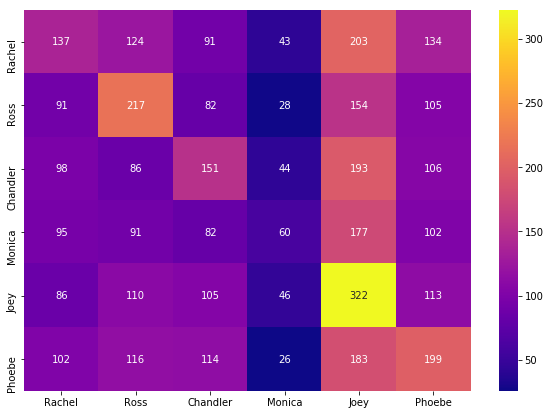

In [43]:
base_test_preds = model.predict(test_x)
base_test_prob = model.predict_proba(test_x)
print(np.mean(base_test_preds == test_y))
print(classification_report(test_y, base_test_preds))
conf_matrix_plot(confusion_matrix(test_y, base_test_preds), major_characters)

## Looking through the results

In [92]:
results = pd.DataFrame({'sentence_full': test_words,
                        'sentence_filtered': test_words_filtered,
                        'sentence_full_length': test_words_length,
                        'sentence_filtered_length': test_words_filtered_length,
                        'y_true': test_y,
                        'y_pred': base_test_preds,
                        'Rachel': base_test_prob[:,np.where(model.classes_=='Rachel')[0][0]],
                        'Ross': base_test_prob[:,np.where(model.classes_=='Ross')[0][0]],
                        'Chandler': base_test_prob[:,np.where(model.classes_=='Chandler')[0][0]],
                        'Monica': base_test_prob[:,np.where(model.classes_=='Monica')[0][0]],
                        'Joey': base_test_prob[:,np.where(model.classes_=='Joey')[0][0]],
                        'Phoebe': base_test_prob[:,np.where(model.classes_=='Phoebe')[0][0]]
                       })

#results[(results['y_true'] == 'Joey') & (results['y_pred'] == 'Joey')].sample(50)
results[results['y_pred'] == 'Monica'].sample(25)

,Chandler,Joey,Monica,Phoebe,Rachel,Ross,sentence_filtered,sentence_filtered_length,sentence_full,sentence_full_length,y_pred,y_true
588,0.155918,0.105904,0.193950,0.169822,0.186995,0.187410,"[well, may, drunk, know, said, went, beefsteak...",8,"[well, may, drunk, know, said, went, beefsteak...",8,Monica,Chandler
4052,0.155870,0.113381,0.225766,0.135840,0.210051,0.159091,"[hey, joey]",2,"[hey, joey]",2,Monica,Joey
365,0.166113,0.165674,0.197317,0.128918,0.163333,0.178646,"[let, tell, need, pick, see, kid, always, left...",42,"[let, tell, need, pick, see, kid, always, left...",42,Monica,Chandler
546,0.166411,0.145083,0.200701,0.138830,0.165069,0.183905,"[went, back, house, got, really, silly, made]",7,"[went, back, house, got, really, silly, made]",7,Monica,Rachel
3846,0.207638,0.153903,0.222626,0.154370,0.120703,0.140760,"[knitting, yes, knit, good]",4,"[knitting, yes, knit, good]",4,Monica,Phoebe
228,0.185264,0.111200,0.303172,0.128476,0.167730,0.104158,"[true, wanted, wear, bathrobe, eat, peanut, cl...",12,"[true, wanted, wear, bathrobe, eat, peanut, cl...",12,Monica,Chandler
3747,0.197370,0.129431,0.220620,0.140792,0.159423,0.152363,"[bills, tried, give, charity, said, dropped, o...",22,"[bills, tried, give, charity, said, dropped, o...",22,Monica,Joey
2434,0.172892,0.152791,0.212486,0.110609,0.207295,0.143927,"[oh, little, rich, boy, problem, butler, yes, ...",9,"[oh, little, rich, boy, problem, butler, yes, ...",9,Monica,Phoebe
2368,0.184164,0.178012,0.242495,0.067840,0.184949,0.142540,[matter],1,[matter],1,Monica,Ross
150,0.165870,0.101584,0.238791,0.146615,0.220079,0.127061,"[joey, going, tell, us, work]",5,"[joey, going, tell, us, work]",5,Monica,Monica


### Looking at Accuracy by Sentence Length

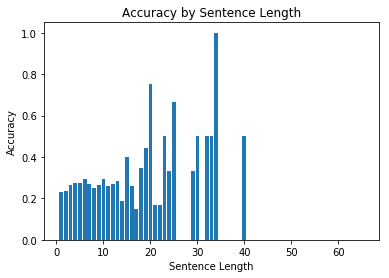

In [84]:
results['correct'] = np.where(results['y_true'] == results['y_pred'], 1, 0)

results_agg = results.groupby(['sentence_filtered_length'])['correct'].mean()
plt.bar(results_agg.index, results_agg)
plt.xlabel('Sentence Length')
plt.ylabel('Accuracy')
plt.title('Accuracy by Sentence Length')
plt.show()